In [4]:
import os

import numpy as np
import tensorflow as tf
from tensorflow.python.data import AUTOTUNE

from aegomoku.game_data import read_training_data

In [5]:
directory = "/Users/wgiersche/workspace/Project-Ellie/DATA/"
filenames = [os.path.join(directory, filename) for filename in os.listdir(directory)]
print(filenames)
BOARD_SIZE=15

['/Users/wgiersche/workspace/Project-Ellie/DATA/00011.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00003.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00001.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00009.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00005.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00007.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00010.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00002.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00012.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00008.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00004.pickle', '/Users/wgiersche/workspace/Project-Ellie/DATA/00006.pickle']


In [6]:
filename = filenames[0]
print(f"Reading from {filename}")
examples = read_training_data(filename, BOARD_SIZE)
len(examples), len(examples[0]), examples[0][0].shape
#examples = examples[:5]

Reading from /Users/wgiersche/workspace/Project-Ellie/DATA/00011.pickle


(6032, 3, (17, 17, 3))

In [7]:
def serialize_example(state, policy, value):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  feature = {
      's': tf.train.Feature(bytes_list=tf.train.BytesList(value=[state])),
      'p': tf.train.Feature(bytes_list=tf.train.BytesList(value=[policy])),
      'v': tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
  }

  # Create a Features message using tf.train.Example.

  e = tf.train.Example(features=tf.train.Features(feature=feature))
  return e.SerializeToString()

In [8]:
outfile = 'test2.tfrecord'

In [9]:
# Write the `tf.train.Example` observations to the file.
with tf.io.TFRecordWriter(outfile) as writer:
    for state, policy, value in examples:
        state = tf.io.serialize_tensor(state.astype(np.uint8)).numpy()
        policy = tf.io.serialize_tensor(np.array(np.array(policy)*255).astype(np.uint8)).numpy()
        example = serialize_example(state, policy, value)
        writer.write(example)

2022-09-05 18:48:31.065567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
s, p, v = examples[0]

In [11]:
len(tf.io.serialize_tensor(s.astype(np.uint8)).numpy())

886

In [12]:
len(tf.io.serialize_tensor(np.array(p).astype(np.uint8)).numpy())

237

In [13]:
filenames = [outfile]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [14]:
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  #print(example)

In [15]:
# Create a description of the features.
feature_description = {
    's': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'p': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'v': tf.io.FixedLenFeature([], tf.float32, default_value=0),
}

dictionary =tf.io.parse_single_example(raw_record, feature_description)
dictionary['p'].numpy()

b'\x08\x04\x12\x05\x12\x03\x08\xe1\x01"\xe1\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<B\x00\x00C<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

In [16]:
def read_tfrecord(example):

    record = tf.io.parse_single_example(example, feature_description)
    s = tf.io.parse_tensor(record['s'], out_type=tf.uint8)
    p = tf.cast(tf.io.parse_tensor(record['p'], out_type=tf.uint8), tf.float32) / 256.
    v = record['v']
    return s, p, v

In [17]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [18]:
def get_dataset(filenames, batch_size):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

In [19]:
ds = get_dataset(outfile, 1)
s, p, v = next(iter(ds))
s.shape, p.shape, v.shape

(TensorShape([1, 17, 17, 3]), TensorShape([1, 225]), TensorShape([1]))

In [20]:
example = np.squeeze(s), list(np.squeeze(p)), np.squeeze(v)

Next to play: WHITE
Value from WHITE's point of view: 0.08457107096910477


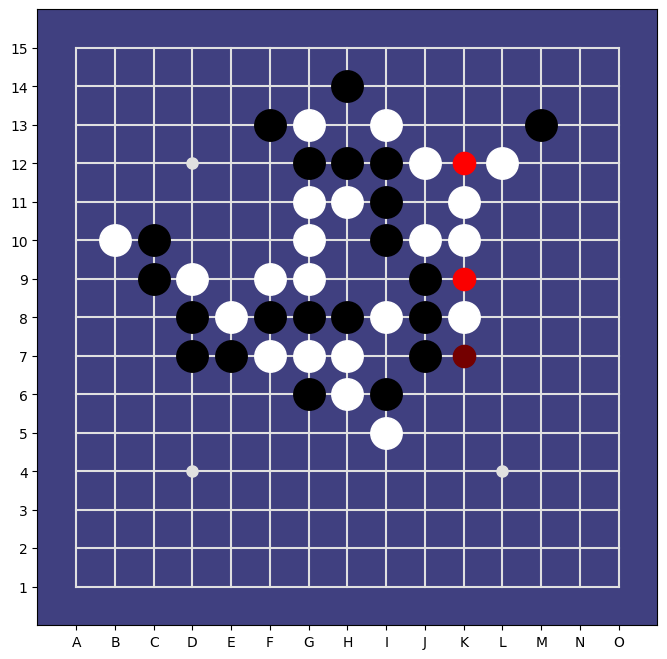

In [21]:
from aegomoku.utils import analyse_example

analyse_example(BOARD_SIZE, example, disp_width=8)

In [24]:
from aegomoku.gomoku_resnet import GomokuResnet

# Note that this model is way too small. We're only demonstrating convergence, here.
model = GomokuResnet(BOARD_SIZE, num_sensor_filters=128, num_blocks=4)
model.compile()
model.summary()

Model: "gomoku_resnet_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 17, 17, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 17, 17, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 17, 17, 128)  46592       ['inputs[0][0]']                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 17, 17, 5)    1540        ['heuristic_detector[0][0]']     
                                                                                    

In [25]:
from aegomoku.trainer import Trainer

trainer = Trainer(model)
ds = get_dataset(outfile, 1024)
trainer.train(ds, epochs_per_train=10, report_every=1)

Epoch: 1, Training: p: 5.289, v: 0.12264 - elapsed: 24.738s
Epoch: 2, Training: p: 5.2254, v: 0.12292 - elapsed: 12.185s
Epoch: 3, Training: p: 5.1641, v: 0.12299 - elapsed: 12.179s
Epoch: 4, Training: p: 5.1013, v: 0.12293 - elapsed: 12.257s
Epoch: 5, Training: p: 5.03, v: 0.12273 - elapsed: 12.251s
Epoch: 6, Training: p: 4.9529, v: 0.12264 - elapsed: 12.283s
Epoch: 7, Training: p: 4.8671, v: 0.12238 - elapsed: 12.213s
Epoch: 8, Training: p: 4.7752, v: 0.12223 - elapsed: 12.082s
Epoch: 9, Training: p: 4.6796, v: 0.12195 - elapsed: 12.064s
Epoch: 10, Training: (4.6795883, 0.12194928)
